In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [37]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

from scipy.integrate import odeint

In [38]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%autoreload 2

# Modèle 04 

## Téléchargement des données

### Météo

In [104]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday = pd.to_datetime('02/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime('now').tz_localize('Europe/Paris')

In [260]:
# download the data:
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

2, 3, 4, 5, 6, 7, done


In [261]:
weatherdata = weatherdata.resample('15min').interpolate('linear')

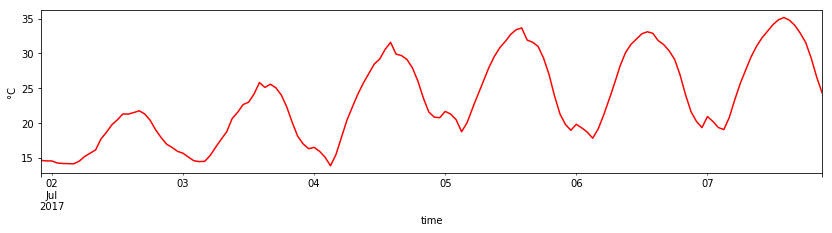

In [262]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

### Irradiation solaire

In [263]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


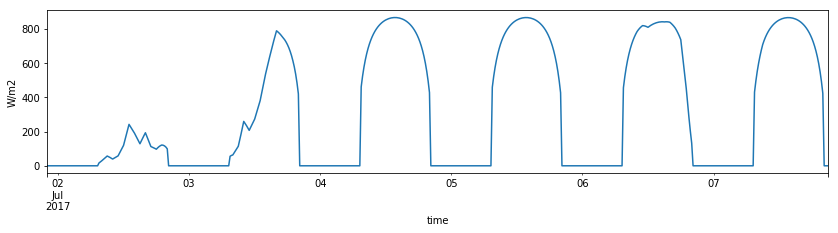

In [264]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

#### Projection sur les surfaces vitrées

In [265]:
sigma = 37  # deg, angle du toit
phi_C = 50  # deg, azimuth du toit

In [266]:
sunFlux_dict = {'flux_bastille':sun.projectDF( 37, 50, sundata ), 
                'flux_cuisine': sun.projectDF( 90, 50, sundata ),
                'flux_vercors': sun.projectDF( 37, 180+50, sundata),
                'flux_chambre': sun.projectDF( 90, 180+50, sundata )}

sunFlux = pd.DataFrame( sunFlux_dict )

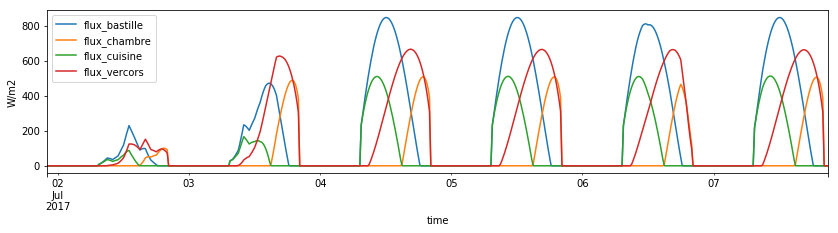

In [267]:
sunFlux.plot(figsize=(14, 3)); plt.ylabel('W/m2');

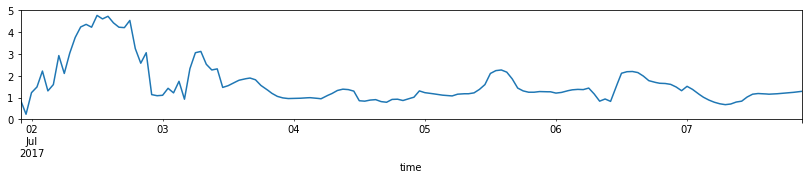

In [268]:
weatherdata['windSpeed'].plot(figsize=(14, 2))

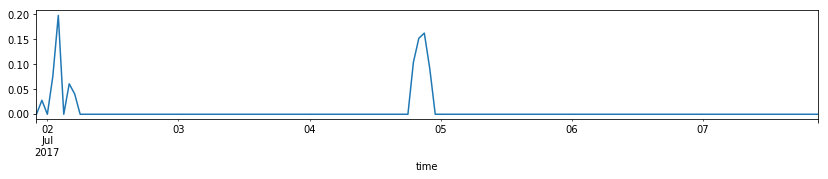

In [269]:
weatherdata['precipIntensity'].plot(figsize=(14, 2))

### Température intérieure mesurée

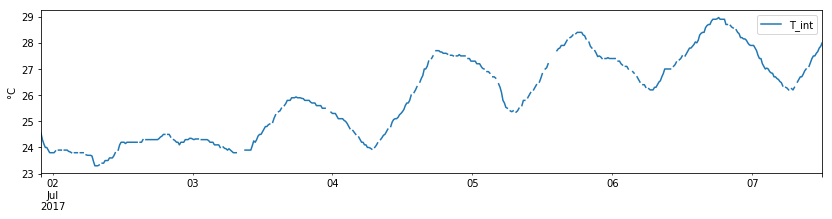

In [277]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday )
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [278]:
# Remove some data 
mask_start = pd.to_datetime( '28/06/2017 22:00' ).tz_localize('Europe/Paris')
mask_end = pd.to_datetime( '29/06/2017 10:00' ) .tz_localize('Europe/Paris')

mask = (Tmesure.index > mask_start) & (Tmesure.index < mask_end )

Tmesure['T_int'].loc[mask] = np.nan

In [281]:
Tmesure = Tmesure.resample('15min').interpolate()

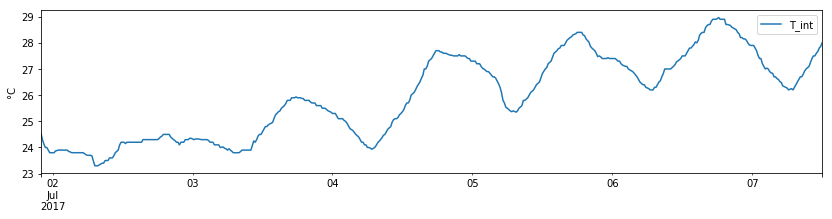

In [282]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [283]:
weatherdata['T_int'] = Tmesure['T_int'].interpolate()

### Look

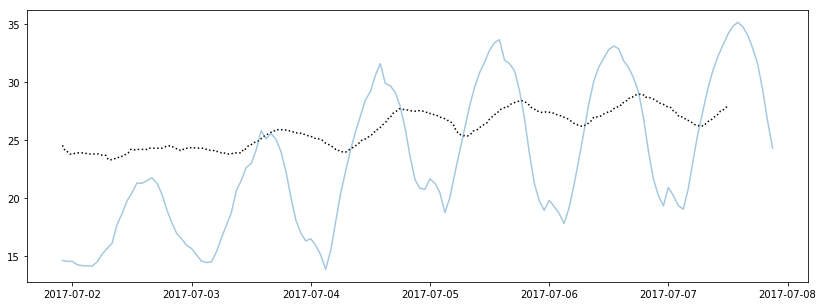

In [287]:
plt.figure( figsize=(14, 5) )

plt.plot(weatherdata['T_int'] , ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

## Grandeurs physiques

propriétés double vitrage: https://www.energieplus-lesite.be/index.php?id=10396#c2234

### fenêtres

In [284]:
windows_size = { 'bastille':(1.2, 0.8),
            'cuisine1':(0.3, 0.72),
           'cuisine2':(0.3, 0.72),
            'chambre1':(0.3, 0.72),
            'chambre2':(0.3, 0.72),
            'vercors1':(0.6, 0.8),
            'vercors2':(0.6, 0.8),
            'sdb':(0.25, 0.25)
          }

In [285]:
def get_Ufenetre( largeur, hauteur ):
    k_vitre = 2.8 # W/m2/K
    surface = hauteur * largeur
    U_vitre = surface*k_vitre # W/K

    # https://www.energieplus-lesite.be/index.php?id=17039
    psi = 0.06 # W/m/K
    perimetre = 2*(hauteur + largeur)
    U_chassis = psi*perimetre # W/K

    Ufenetres = U_vitre + U_chassis
    
    return Ufenetres

In [120]:
Ufenetres = sum(  [ get_Ufenetre( *dim ) for dim in windows_size.values() ] )

print('Ufenetres: %.2f W/K'%Ufenetres)

Ufenetres: 9.10 W/K


#### Rayonement

In [121]:
Facteur_g = 0.76 # Facteur solaire (prend en compte l'absorption et la ré-émission)

In [122]:
def surf( k ):
    return windows_size[k][0]*windows_size[k][1]

In [123]:
weatherdata['flux_tot'] =( surf('bastille')*sunFlux_dict['flux_bastille'] \
            + 2*surf('cuisine1')*sunFlux_dict['flux_cuisine'] \
            + 2*surf('chambre1')*sunFlux_dict['flux_chambre']\
            + 2*surf('vercors1')*sunFlux_dict['flux_vercors'] ) * Facteur_g

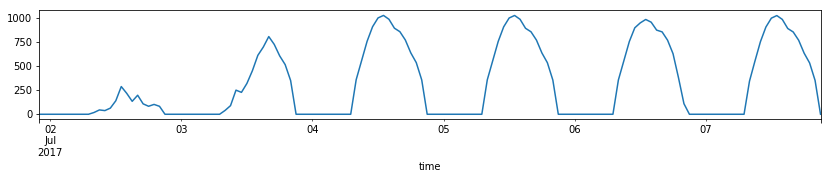

In [124]:
weatherdata['flux_tot'].plot(figsize=(14, 2))

### Masse thermique mur & sol

In [233]:
Ri = 0.13  # coef échange intérieure mur, W/m2/K
S_wall = 58 + 2*22.7 # m2

U_wall = 1/Ri*S_wall

print( 'U_wall= %0.2f W/K' %U_wall )

U_wall= 795.38 W/K


In [234]:
rhoCp = 1400e3 # densité*Capacité thermique, J/m3/K
k = 1.75  #  conductivité, W/m/K

alpha = k/rhoCp # diffusivité, s.m-2

#print('temps caractériqtique: %.2f h'%(ep_wall**2/alpha/60/60))
print('epaisseur caractériqtique: %.2f cm'% ( 100*np.sqrt( alpha*24*60*60 ) ))

epaisseur caractériqtique: 32.86 cm


### Air :

In [235]:
Volume = 22.7*7.94 # m2
rhoCp_air = 1256 # J/m3/K 

Mth_air = rhoCp_air*Volume

#### Aération

In [236]:
taux = 0.5 # Volume / heure
U_aeration = taux * Volume/60/60 * rhoCp_air

In [237]:
print( 'U_aeration= %0.2f W/K' % U_aeration )

U_aeration= 31.44 W/K


In [238]:
coeffs = {}
coeffs['U_ext'] = U_aeration + Ufenetres

coeffs['alpha'] = alpha
coeffs['rhoCp'] = rhoCp

coeffs['h_wall'] = 1/Ri
coeffs['U_wall'] = U_wall

coeffs['Mth_air'] = Mth_air

coeffs['L'] = 0.08  #m 


## Solveur simple

In [239]:
""" Interpolation des données météo
"""
data_dict = weatherdata.to_dict(orient='list')
time_sec = weatherdata.index.astype(np.int64) // 10e9

def interpoldata( t, key):
    data = np.interp( t, time_sec, data_dict[key] )
    return data

In [240]:
def get_dTdt_simple( T, t, coeffs ):
    
    Tint = T[0]
    Twall = T[1]

    dTdt = np.zeros_like( T )
    
    #weatherdata = interpoldata(  t, 'temperature' )
    T_ext = interpoldata(  t, 'temperature' )
    flux_tot =  coeffs['eta'] * interpoldata(  t, 'flux_tot' )
        
    dTdt[0] = 1/coeffs['Mth_air']*( coeffs['U_ext']*( T_ext - Tint ) + \
                           coeffs['U_wall']*( Twall - Tint ) + flux_tot )
    

    dTdt[1] = coeffs['h_wall']/coeffs['rhoCp']/coeffs['L']*( Tint - Twall ) # rhoCp ?? 
    
    return dTdt

In [241]:
def Model04_apply( coeffs ):
    
    Tzero_simple = np.ones(2) * 25 # weatherdata['temperature'].mean()
    
    # Calcul :
    res = odeint(get_dTdt_simple, Tzero_simple, time_sec, args=(coeffs, ), rtol=1e-2, atol=1e-2, h0=1200)
    
    cols = {'T_theo':res[:, 0], 'T_wall':res[:, 1] }
    results = pd.DataFrame(  cols, index=weatherdata.index )
    return results

In [242]:
coeffs

{'L': 0.08,
 'Mth_air': 226378.92799999999,
 'U_ext': 40.53731777777777,
 'U_wall': 795.3846153846154,
 'alpha': 1.25e-06,
 'h_wall': 7.692307692307692,
 'rhoCp': 1400000.0}

In [243]:
coeffs['rhoCp']* coeffs['L'] / coeffs['h_wall'] / 60 / 60

4.044444444444445

In [244]:
coeffs['Mth_air'] / coeffs['U_ext'] / 60 / 60

1.551238192429878

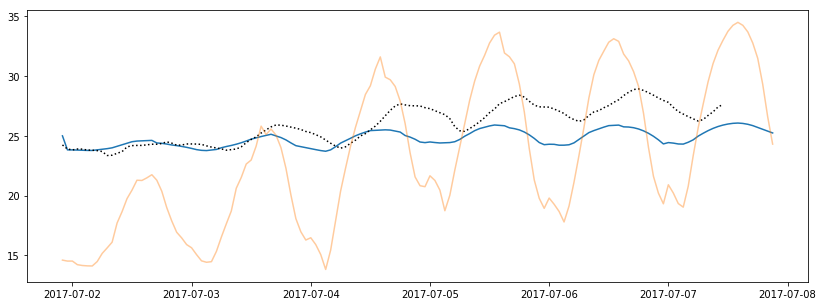

In [245]:
coeffs['U_ext'] = 100
coeffs['eta'] = 0.07000
coeffs['L'] = 0.8  #m 
coeffs['Mth_air'] = 22000  #m 

results = Model04_apply( coeffs )

plt.figure( figsize=(14, 5) )
plt.plot(results['T_theo'])
plt.plot(Tmesure, ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

## Fit sur toutes les données

In [193]:
def errorfit( coeffs ):
    
    results = Model04_apply( coeffs )

    return np.sum( ( Tmesure['T_int'] - results['T_theo'] )**2 )

In [194]:
errorfit( coeffs )

268.31334599656213

In [195]:
from scipy.optimize import minimize

In [180]:
coeffs['U_ext'] = 45
coeffs['eta'] = 0.7000
coeffs['L'] = 0.0000051082  #m 
coeffs['Mth_air'] = 226300  #m 

In [227]:
variables =  ['Mth_air', 'L'] # 'L'] #, 'U_wall']  'eta', 'U_ext', 

v0 = [ coeffs[k] for k in variables  ]

T_int = Tmesure['T_int']

def get_errorfit( args ):
    params_fit = coeffs.copy()

    for i in range( len( variables ) ):
        params_fit[ variables[i] ] = args[i]
        
    ef = errorfit( params_fit )
    
    return ef

In [228]:
v0

[22000, 0.008]

In [229]:
var_res = minimize(get_errorfit, v0, tol=1e-1, method='Powell', options={'disp': True})

Optimization terminated successfully.
         Current function value: 361.524247
         Iterations: 2
         Function evaluations: 27


In [230]:
params_opti = coeffs.copy()
for i in range( len( variables ) ):
    params_opti[ variables[i] ] = var_res.x[i]
    print( '%s : %f' % ( variables[i], var_res.x[i] ) )
    
print( params_opti )

Mth_air : 22000.486911
L : -0.922169
{'U_ext': 100, 'rhoCp': 1400000.0, 'L': -0.92216949233921142, 'h_wall': 7.692307692307692, 'eta': 0.07, 'U_wall': 795.3846153846154, 'Mth_air': 22000.486911451197, 'alpha': 1.25e-06}


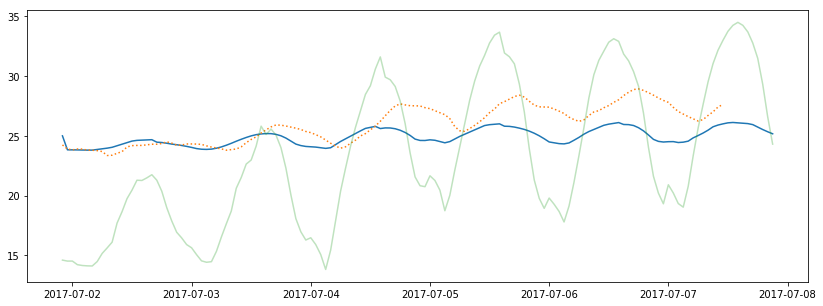

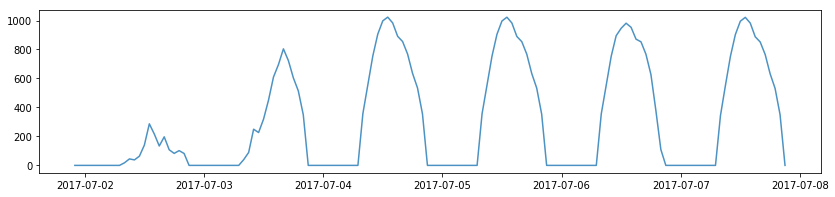

In [231]:
results = Model04_apply( params_opti )

plt.figure( figsize=(14, 5) )
plt.plot(results['T_theo'])
plt.plot(Tmesure['T_int'], ':')
plt.plot(weatherdata['temperature'], alpha=0.3);

plt.figure( figsize=(14, 3) )
plt.plot(weatherdata['flux_tot'], alpha=0.8);

### Flux puissance air <-> Masse thermique

In [102]:
F =  coeffs['U_wall']*( results['T_theo'] - results['T_wall'] )

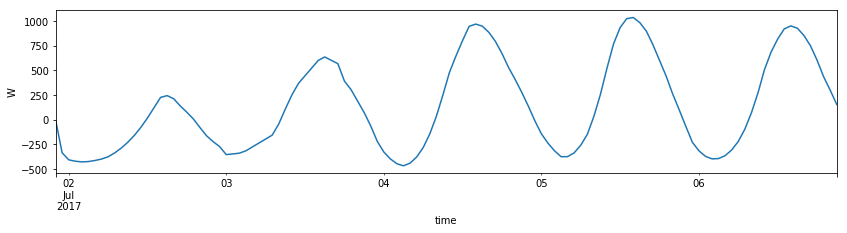

In [103]:
F.plot( figsize=(14, 3)); plt.ylabel('W');

In [80]:
weatherdata.columns

Index(['cloudCover', 'precipIntensity', 'temperature', 'windBearing',
       'windSpeed', 'T_int', 'flux_tot'],
      dtype='object')

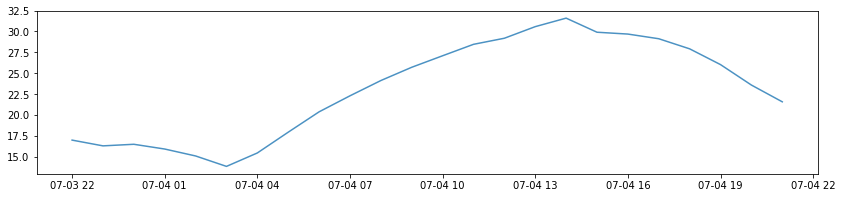

In [81]:
plt.figure( figsize=(14, 3) )
plt.plot(weatherdata['temperature'][-24*3:-24*2], alpha=0.8);

### Fit par morceaux

In [82]:
def Model04_onestep( coeffs, Tzero, time_span ):
        
    # Calcul :
    res = odeint(get_dTdt_simple, Tzero, time_span, args=(coeffs, ))
    
    return res

In [83]:
T_int = weatherdata['T_int'].as_matrix()
T_init_int = results['T_theo'].as_matrix()
T_init_wall = results['T_wall'].as_matrix()

In [84]:
def get_error_onestep( params, Tinit, T_int_step, time_span ):
    coeffs['eta'] = params[0]
    coeffs['U_ext'] = params[1]
    
    res = Model04_onestep( coeffs, Tinit, time_span )
    return np.sum( (T_int_step - res[:, 0])**2 )

In [85]:
def opti_onestep( eta, U_ext, Tinit, i, n  ):
    T_int_step = T_int[i:i+n]
    time_span = time_sec[i:i+n]
    
    if np.isnan(T_int_step).any():
        return eta, U_ext, Tinit
    else:
        v0 = [eta, U_ext]
        var_res = minimize(get_error_onestep, v0, tol=1e-2, method='Powell', args=(Tinit, T_int_step, time_span))
        
        coeffs['eta'] = var_res.x[0]
        coeffs['U_ext'] = var_res.x[1]    
        
        T_new = Model04_onestep( coeffs, Tinit, time_span )
        return var_res.x[0], var_res.x[1], T_new

In [86]:
coeffs

{'L': 0.0082,
 'Mth_air': 226378.92799999999,
 'U_ext': 45,
 'U_wall': 795.3846153846154,
 'alpha': 1.25e-06,
 'eta': 0.7,
 'h_wall': 7.692307692307692,
 'rhoCp': 1400000.0}

In [87]:
i_start = 65
n = 6

eta_t = [0.6]
U_ext_t = [45]
T_theo = [T_init_int[i_start]]
T_wall = [T_init_wall[i_start]]

for i in range( i_start, 200, n):
    
    Tzero = [ T_theo[-1], T_wall[-1]  ]
    eta, U_ext, Tnew = opti_onestep( 0.6, 45, [T_theo[-1], T_wall[-1]], i, n  )
    
    eta_t.append( eta )
    U_ext_t.append( U_ext  )
    T_theo.extend( Tnew[:, 0] )
    T_wall.extend( Tnew[:, 1] )

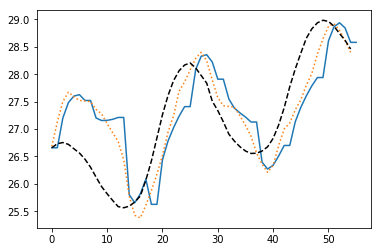

In [88]:
plt.plot( T_theo )

N = len( T_theo )
plt.plot( T_int[i_start:i_start + N], ':' )

plt.plot( T_init_int[i_start:i_start + N], 'k--' )

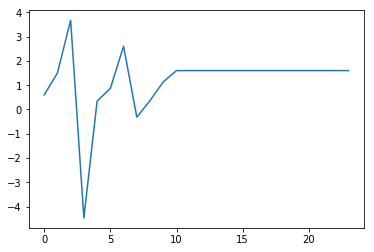

In [89]:
plt.plot( eta_t  )

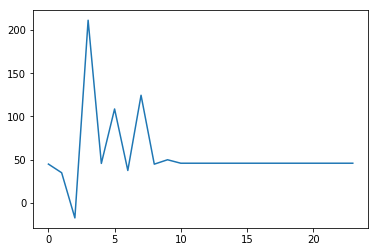

In [90]:
plt.plot( U_ext_t  )

In [91]:
i = 65
n = 6

eta, U_ext, Tnew = opti_onestep( 0.6, 45, [T_init_int[i], T_init_wall[i]], i, n  )

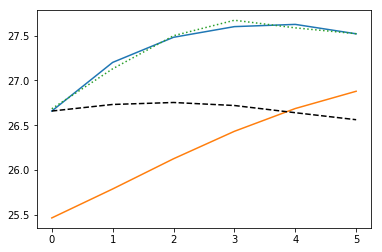

In [92]:
plt.plot( Tnew )
plt.plot( T_int[i:i+n], ':' )

plt.plot( T_init_int[i:i+n], 'k--' )

In [93]:
eta, U_ext

(1.4998842281076679, 35.00337961113889)

In [94]:
T_int[65]

26.683333555857331

In [95]:
17*3

51